# 2.Improving Deep Neural Networks:Hyperparameter Tuning,Regularization and Optimization

## 2.4optimization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils import load_params_and_grads, initialize_parameters,forward_propagation, backward_propagation
from opt_utils import compute_cost, predict, predict_dec,plot_decision_boundary, load_dataset
from testCases_opt import *

#matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural networks
    
    # Update rule for each parameter
    for l in range(L):
        ### START CODE HERE ### (approx. 2 lines)
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads['db' + str(l+1)]
        ### END CODE HERE ###
    return parameters

In [13]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    np.random.seed(seed) # To make your "random" minibatches the same as ours
    m = X.shape[1] # number of training examples
    mini_batches = []
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, mini_batch_size*k:mini_batch_size*(k+1)]
        mini_batch_Y = shuffled_Y[:, mini_batch_size*k:mini_batch_size*(k+1)]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:,num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches * mini_batch_size : m]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

In [14]:
def initialize_velocity(parameters):
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(L):
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        ### END CODE HERE ###
    return v

In [15]:
def update_parameters_with_momentum(parameters, grads, v, beta,learning_rate):
    L = len(parameters) // 2 # number of layers in the neural networks
    # Momentum update for each parameter
    for l in range(L):
        ### START CODE HERE ### (approx. 4 lines)
        # compute velocities
        v["dW" + str(l+1)] = beta * v["dW" + str(l+1)] +(1- beta )* grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta * v["db" + str(l+1)] +(1- beta )* grads['db' + str(l+1)]
        # update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate * v["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate * v["db" + str(l+1)]
        ### END CODE HERE ###
    return parameters, v

In [16]:
def initialize_adam(parameters) :
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        ### START CODE HERE ### (approx. 4 lines)
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        ### END CODE HERE ###
    return v, s

In [22]:
def update_parameters_with_adam(parameters, grads, v, s, t,learning_rate = 0.01, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
    L = len(parameters) // 2 # number of layers in the neural networks
    v_corrected = {}
    s_corrected = {} # Initializing second moment estimate, python
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)]+(1-beta1)*grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)]+(1-beta1)*grads['db' + str(l+1)]
        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1-math.pow(beta1,t))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1-math.pow(beta1,t))
        # Moving average of the squared gradients. Inputs: "s, grads,beta2". Output: "s".
        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)]+(1-beta2)*(grads['dW' + str(l+1)]**2)
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)]+(1-beta2)*(grads['db' + str(l+1)]**2)
        # Compute bias-corrected second raw moment estimate. Inputs:"s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-math.pow(beta2,t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-math.pow(beta2,t))
        # Update parameters. Inputs: "parameters, learning_rate,v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" +str(l+1)]-learning_rate * v_corrected["dW" +str(l+1)]/(np.sqrt(s_corrected["dW" + str(l+1)])+epsilon)
        parameters["b" + str(l+1)] = parameters["b" +str(l+1)]-learning_rate * v_corrected["db" +str(l+1)]/(np.sqrt(s_corrected["db" + str(l+1)])+epsilon)
    return parameters, v, s

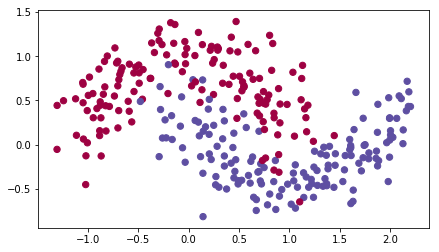

In [23]:
train_X, train_Y = load_dataset()

In [25]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007,\
mini_batch_size = 64, beta = 0.9, beta1 = 0.9, beta2 = 0.999,\
epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    L = len(layers_dims) # number of layers in the neural networks
    costs = [] # to keep track of the cost
    t = 0 # initializing the counter required for Adam update
    seed = 10 # For grading purposes, so that your "random" minibatches are the same as ours
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)
    
    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        # Define the random minibatches. We increment the seed toreshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        
        for minibatch in minibatches:
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            
            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)
            
            # Compute cost
            cost = compute_cost(a3, minibatch_Y)
            
            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y,caches)
            
            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters,grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v =\
                update_parameters_with_momentum(parameters, grads,v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v,s, t, learning_rate, beta1, beta2, epsilon)
    
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
    return parameters

Cost after epoch 0: 0.690736
Cost after epoch 1000: 0.685273
Cost after epoch 2000: 0.647072
Cost after epoch 3000: 0.619525
Cost after epoch 4000: 0.576584
Cost after epoch 5000: 0.607243
Cost after epoch 6000: 0.529403
Cost after epoch 7000: 0.460768
Cost after epoch 8000: 0.465586
Cost after epoch 9000: 0.464518


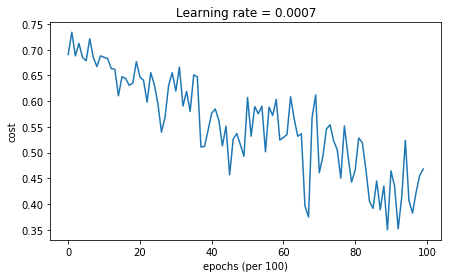

Accuracy: 0.7966666666666666


In [26]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")
# Predict
predictions = predict(train_X, train_Y, parameters)

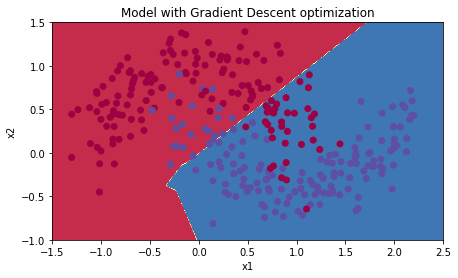

In [27]:
# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X,train_Y)

Cost after epoch 0: 0.690741
Cost after epoch 1000: 0.685341
Cost after epoch 2000: 0.647145
Cost after epoch 3000: 0.619594
Cost after epoch 4000: 0.576665
Cost after epoch 5000: 0.607324
Cost after epoch 6000: 0.529476
Cost after epoch 7000: 0.460936
Cost after epoch 8000: 0.465780
Cost after epoch 9000: 0.464740


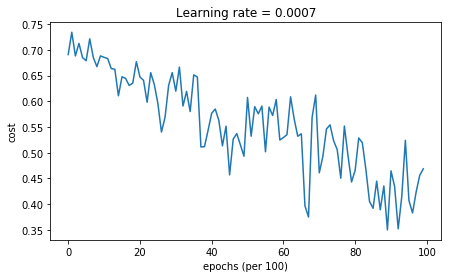

Accuracy: 0.7966666666666666


In [28]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer= "momentum")
# Predict
predictions = predict(train_X, train_Y, parameters)

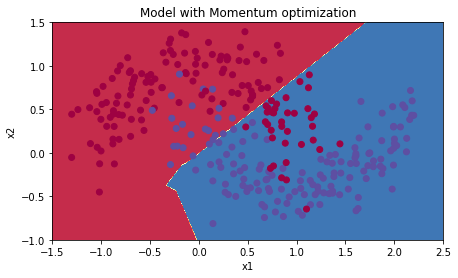

In [29]:
# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X,train_Y)

Cost after epoch 0: 0.690552
Cost after epoch 1000: 0.185567
Cost after epoch 2000: 0.150852
Cost after epoch 3000: 0.074454
Cost after epoch 4000: 0.125936
Cost after epoch 5000: 0.104235
Cost after epoch 6000: 0.100552
Cost after epoch 7000: 0.031601
Cost after epoch 8000: 0.111709
Cost after epoch 9000: 0.197648


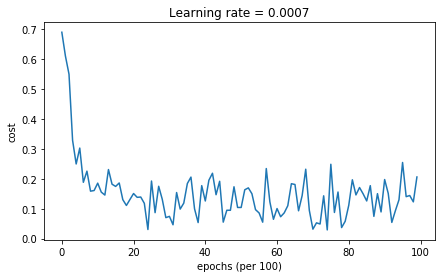

Accuracy: 0.94


In [30]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")
# Predict
predictions = predict(train_X, train_Y, parameters)

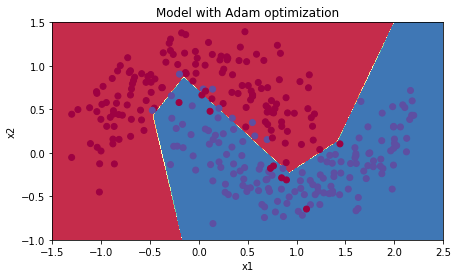

In [31]:
# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X,train_Y)